## PySpark - Fundamentals


In [4]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import datetime
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### Pi Calculation

In [2]:
sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)
sc.stop()

3.14177504


### SQL Basics with Spark

In [5]:
spark = SparkSession \
        .builder \
        .appName("Wrangling Data") \
        .getOrCreate()

In [6]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

In [7]:
type(user_log)

pyspark.sql.dataframe.DataFrame

### Select statements

In [ ]:
user_log.take(5)

In [ ]:
user_log.describe().show()

In [11]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [12]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [13]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [14]:
user_log.count()

10000

In [ ]:
# select columns come first then where/filter
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

In [25]:
# example of timestamp
user_log.select('ts').take(5)

[Row(ts=1513720872284),
 Row(ts=1513720878284),
 Row(ts=1513720881284),
 Row(ts=1513720905284),
 Row(ts=1513720913284)]

### User defined functions

In [23]:
# hour from timestamp
datetime.datetime.fromtimestamp(1513720872284 / 1000.0).hour

23

In [29]:
# working with udf
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [ ]:
user_log.head(5)

In [37]:
# where -> filter, groupby then count, orderby, select (filter, groupBy, orderBy, select[take/head])
songs_by_hours = user_log\
                .filter(user_log.page == "NextSong")\
                .groupby(user_log.hour)\
                .count()\
                .orderBy(user_log.hour.cast("float"))

In [39]:
songs_by_hours.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  456|
|   2|  454|
|   3|  382|
|   4|  302|
|   5|  352|
|   6|  276|
|   7|  348|
|   8|  358|
|   9|  375|
|  10|  249|
|  11|  216|
|  12|  228|
|  13|  251|
|  14|  339|
|  15|  462|
|  16|  479|
|  17|  484|
|  18|  430|
|  19|  362|
+----+-----+
only showing top 20 rows



### Data Manipulation & Plotting with Pandas and Matplotlib

In [41]:
songs_in_hour_pd = songs_by_hours.toPandas()
type(songs_in_hour_pd)

pandas.core.frame.DataFrame

In [42]:
# The default return dtype is float64 or int64 depending on the data supplied. 
# Use the downcast parameter to obtain other dtypes.
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

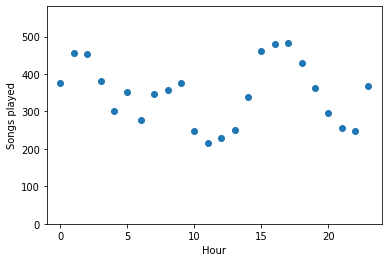

In [43]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

### Drop rows with n/a, duplicates, missing values

In [46]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [47]:
user_log_valid.count()

9664

### More Exploration

In [48]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  12|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


**select(*cols) (transformation)** - Projects a set of expressions and returns a new DataFrame.
Parameters: cols – list of column names (string) or expressions (Column). If one of the column names is ‘*’, that column is expanded to include all columns in the current DataFrame.**

**collect ()** - Return all the elements of the dataset as an array at the driver program. This is usually useful after a filter or other operation that returns a sufficiently small subset of the data.

In [50]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").show()

+------+---------+--------+-----+--------------------+
|userId|firstname|    page|level|                song|
+------+---------+--------+-----+--------------------+
|  1138|    Kelly|    Home| paid|                null|
|  1138|    Kelly|NextSong| paid| Everybody Everybody|
|  1138|    Kelly|NextSong| paid|               Gears|
|  1138|    Kelly|NextSong| paid|        Use Somebody|
|  1138|    Kelly|NextSong| paid|Love Of My Life (...|
|  1138|    Kelly|NextSong| paid|Down In The Valle...|
|  1138|    Kelly|NextSong| paid|Treat Her Like A ...|
|  1138|    Kelly|NextSong| paid|Everybody Thinks ...|
|  1138|    Kelly|NextSong| paid|      Fourteen Wives|
|  1138|    Kelly|NextSong| paid|   Love On The Rocks|
|  1138|    Kelly|NextSong| paid|           Breakeven|
|  1138|    Kelly|NextSong| paid|          Leaf House|
|  1138|    Kelly|NextSong| paid|       NAISEN KANSSA|
|  1138|    Kelly|NextSong| paid|  You're In My Heart|
|  1138|    Kelly|NextSong| paid|Roll On Down The ...|
|  1138|  

In [51]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [52]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [53]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='23', downgraded=0)

### Partition by

In [54]:
from pyspark.sql import Window

In [ ]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)